Dog Breed Classification

In [ ]:
# Select the kaggle.json file downloaded from kaggle account settings page
from google.colab import files
files.upload()

In [ ]:
# Install kaggle API client
!pip install -q kaggle

In [ ]:
# now kaggle expects this file into a kaggle folder so put it there by creating directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This (permission change) avoids a warning on kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [ ]:
# Getting the data set
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           2771          6  0.1764706        


In [ ]:
# Downloading the dataset from the command and come out of the directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp

 99% 681M/691M [00:06<00:00, 169MB/s]
100% 691M/691M [00:06<00:00, 111MB/s]


In [ ]:
%cd ..

/content


In [ ]:
# unzipping downloaded file and removing unusable files
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv
# the rm command is used to remove the above 2 files

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [ ]:
# Import libraries and start building model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
#from keras.preprocessing import image , it is depricated in new tensorflow version
from sklearn.preprocessing import label_binarize    #for binarizing our data
from sklearn.model_selection import train_test_split
from keras.models import Sequential   #for using sequential model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D  # the layers
from keras.optimizers import Adam  # adam is kind of optimizer

In [ ]:
# Read the labels.csv file and check shape and records
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head() 

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
#Visualize the number of each breeds
breeds_all = labels_all["breed"]
breed_count = breeds_all.value_counts()
breed_count.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [ ]:
# Selecting first 3 breeds (due to limitation of our computational power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [ ]:
from tensorflow.keras.utils import load_img
import keras.utils as image

In [ ]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy arrays and normalizing dataset
for i in tqdm(range(len(labels))):
    img = load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x/255.0  #Reducing the dimensions of the image

#Printing train image and one hot encode shape & size
print('\nTrain Image shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size {:,}'.format(Y_data.size))


100%|██████████| 357/357 [00:01<00:00, 300.40it/s]


Train Image shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size 1,071


Train Image shape: (total no. of images, x,y, RGB)

One- ... (total no. of images, considered classes)


In [ ]:
# Building the model:
# Aapplying layers one by one

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2))) # this one finds out most dominant feature in a 2 by 2 layer
# we can change the no. of filters as per which one provide best accuracy, this is called hyper parameter tuning

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation = 'relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation = 'relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer='l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer='l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

We create a network architecture for the model. We used different layers as per their features:

Conv_2D which is used to create a convolutional kernel that is convolved with the imput layer to produce the output tensor.

max_pooling2D is a kind of downsampling technique which takes out the maximum value over the window defined by pool size.

flatten generates a 1D output.

Dense layer produces the output as the dot product of the imput and the kernel.

For compiling we use categorical_crossentropy because we considered only 3 classes, for like 30-40 classes we have to use sparse_categorical_crossentropy, adam is the optimizer here with rate set as 0.0001.

In [ ]:
# Splitting the data set into training and testing set
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)

#Splitting the train data into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [ ]:
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size= batch_size, epochs = epochs, validation_data = (X_val, Y_val))

Epoch 1/100
2/2 [==============================] - 13s 1s/step - loss: 4.9170 - accuracy: 0.2695 - val_loss: 4.9011 - val_accuracy: 0.3231
Epoch 2/100
2/2 [==============================] - 1s 351ms/step - loss: 4.8890 - accuracy: 0.3711 - val_loss: 4.8768 - val_accuracy: 0.2769
Epoch 3/100
2/2 [==============================] - 1s 365ms/step - loss: 4.8631 - accuracy: 0.3672 - val_loss: 4.8533 - val_accuracy: 0.2769
Epoch 4/100
2/2 [==============================] - 1s 385ms/step - loss: 4.8368 - accuracy: 0.3672 - val_loss: 4.8292 - val_accuracy: 0.2769
Epoch 5/100
2/2 [==============================] - 1s 316ms/step - loss: 4.8108 - accuracy: 0.3750 - val_loss: 4.8054 - val_accuracy: 0.2769
Epoch 6/100
2/2 [==============================] - 1s 313ms/step - loss: 4.7855 - accuracy: 0.3633 - val_loss: 4.7829 - val_accuracy: 0.2769
Epoch 7/100
2/2 [==============================] - 1s 315ms/step - loss: 4.7595 - accuracy: 0.3633 - val_loss: 4.7589 - val_accuracy: 0.2769
Epoch 8/100
2/2

We have trained the model on 100 epochs and a batch size of 128. Epoches determines the accuracy. We can also see how the model is performing by viewing the training and validation accuracy at each epoch. Don't forget to change the hardware accelerator to GPU otherwise it could take hours to complete.

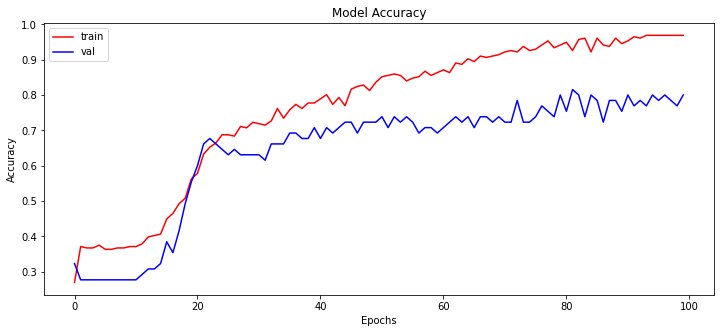

In [ ]:
# Plot the training history

plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()


In [ ]:
# Finally making predictions and also finding out the accuracy on the test set

Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n', round((score[1]*100), 2), '%')


2/2 [==============================] - 0s 12ms/step - loss: 3.1900 - accuracy: 0.7222
Accuracy over the test set: 
 72.22 %


In order to get higher accuracies we can try out changing the hyperparameters :
kernel size, no. of layers, no. of neurons in the dense layer, activation function, optimizers, initializers ... 

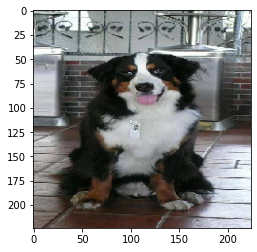

Originally : scottish_deerhound
Predicted : scottish_deerhound


In [ ]:
#Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

#Finding max value from prediction list and comparing original value vs predicted
print("Originally :", labels['breed'][np.argmax(Y_test[1])])
print("Predicted :", labels['breed'][np.argmax(Y_pred[1])])